<a href="https://colab.research.google.com/github/melinadwisafitri/skripsi_price_predict/blob/main/telur_ayam_ras_segar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import Library

In [1]:
import urllib.request
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
import math

from keras.utils.vis_utils import plot_model
from tensorflow.data import Dataset
from tensorflow.keras.losses import Huber
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv1D, LSTM, Dense, Dropout
from tensorflow.keras.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error, RootMeanSquaredError

## time step generator

In [2]:
def time_step_generator(data, time_size, batch_size, shuffle_data):
  dataset = Dataset.from_tensor_slices(data)
  dataset = dataset.window(time_size+1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda x: x.batch(time_size+1))
  dataset = dataset.shuffle(shuffle_data)
  dataset = dataset.map(lambda x: (x[:-1], x[-1]))
  return dataset.batch(batch_size).prefetch(1)

def forecast_predict(model, data, time_size, batch_size):
  generate_data = Dataset.from_tensor_slices(data)
  add_window_step = generate_data.window(time_size, shift=1, drop_remainder=True)
  flatten_window = add_window_step.flat_map(lambda window: window.batch(time_size))
  batch_window = flatten_window.batch(batch_size).prefetch(1)
  model_predict = model.predict(batch_window)
  return model_predict

## Load data

In [3]:
url ='https://github.com/melinadwisafitri/skripsi_price_predict/blob/main/data_pangan/data_fixs/data_new.csv?raw=true'
urllib.request.urlretrieve(url, 'data_pangan.csv')

('data_pangan.csv', <http.client.HTTPMessage at 0x7f011be10850>)

In [4]:
dataset = pd.read_csv('data_pangan.csv')
dataset.head()

,date,beras,beras_kualitas_bawah_i,beras_kualitas_bawah_ii,beras_kualitas_medium_i,beras_kualitas_medium_ii,beras_kualitas_super_i,beras_kualitas_super_ii,daging_ayam_ras_segar,daging_sapi_kualitas_1,...,cabai_rawit,cabai_rawit_hijau,cabai_rawit_merah,minyak_goreng,minyak_goreng_curah,minyak_goreng_kemasan_bermerk_1,minyak_goreng_kemasan_bermerk_2,gula_pasir,gula_pasir_kualitas_premium,gula_pasir_lokal
0,2017-01-08,11200,10150,9650,11250,11150,12750,12250,34100,118400,...,41050,34800,47550,13950,12250,15050,14350,14900,16800,13250
1,2017-01-11,11400,10350,9900,11500,11300,12900,12350,30350,117000,...,30000,30000,30450,13900,12250,14950,14300,14500,16550,12900
2,2017-01-12,10700,9650,8500,11200,10950,12250,11850,29350,115800,...,33300,31500,35050,14000,12150,15400,14400,14800,16650,12950
3,2017-02-08,11200,10150,9650,11250,11150,12750,12250,34150,118400,...,40600,34600,46650,13950,12250,15050,14350,14900,16800,13250
4,2017-02-10,11400,10250,9850,11400,11250,12850,12350,30200,118400,...,31850,32550,31550,14000,12350,15000,14350,14700,16750,12950


In [5]:
dataset['date'] = pd.to_datetime(dataset['date'])

In [6]:
dataset = dataset.set_index('date')
dataset = dataset.sort_index()
train = dataset.telur_ayam_ras_segar.values
date = dataset.index

## Train test val split

In [7]:
x_train, x_test, y_train, y_test = train_test_split(train, date, test_size=0.2, random_state=False, shuffle=False)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.125, random_state=False, shuffle=False) # 0.125 x 0.48 = 0.1

print(f'{len(x_train)}\n{len(x_test)}')

818
234


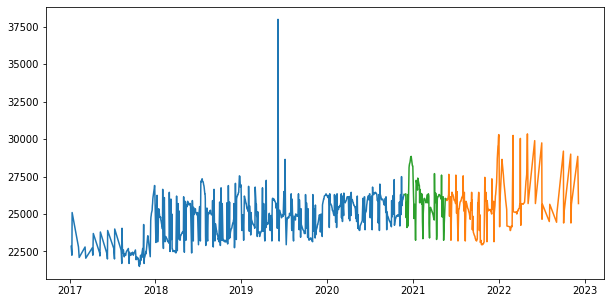

In [8]:
plt.figure(figsize=(10, 5))
plt.plot(y_train, x_train)
plt.plot(y_test, x_test)
plt.plot(y_val, x_val)
plt.show()

## data generate

In [9]:
scal_range= MinMaxScaler(feature_range=(0,1))
train_scal = scal_range.fit_transform(x_train.reshape(-1, 1))
test_scal = scal_range.fit_transform(x_test.reshape(-1, 1))
val_scal = scal_range.fit_transform(x_val.reshape(-1, 1))
train_step = time_step_generator(train_scal, time_size=600, shuffle_data=100, batch_size=5)
val_step = time_step_generator(val_scal, time_size=80, shuffle_data=100, batch_size=20)
test_step = time_step_generator(test_scal, time_size=150, shuffle_data=1000, batch_size=5)

train_step1 = time_step_generator(train_scal, time_size=100, shuffle_data=100, batch_size=1)
val_step1 = time_step_generator(val_scal, time_size=1, shuffle_data=10, batch_size=1)
test_step1 = time_step_generator(test_scal, time_size=10, shuffle_data=100, batch_size=1)

train_step2 = time_step_generator(train_scal, time_size=400, shuffle_data=1000, batch_size=5)
val_step2 = time_step_generator(val_scal, time_size=50, shuffle_data=100, batch_size=2)
test_step2 = time_step_generator(test_scal, time_size=100, shuffle_data=1000, batch_size=5)

## model 

### SGD

In [10]:
model= Sequential([
    Conv1D(16, kernel_size=2, activation='relu',padding='causal', strides=2, input_shape=[None, 1]),
        LSTM(24, return_sequences=True),
        LSTM(20),
        Dense(64, activation='relu'),
        Dense(1)
])

model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=1e-4, momentum=0.9), loss='mse', metrics=['mae', 'mape'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, None, 16)          48        
                                                                 
 lstm (LSTM)                 (None, None, 24)          3936      
                                                                 
 lstm_1 (LSTM)               (None, 20)                3600      
                                                                 
 dense (Dense)               (None, 64)                1344      
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 8,993
Trainable params: 8,993
Non-trainable params: 0
_________________________________________________________________


In [11]:
# plot_model(model, to_file='model1_plot.png', show_shapes=True, show_layer_names=True)

#### type1

In [12]:
history = model.fit(train_step, epochs=30, validation_data=val_step)

Epoch 1/30
44/44 [==============================] - 21s 279ms/step - loss: 0.0604 - mae: 0.2410 - mape: 99.8731 - val_loss: 0.2119 - val_mae: 0.4259 - val_mape: 270479.9688
Epoch 2/30
44/44 [==============================] - 8s 189ms/step - loss: 0.0388 - mae: 0.1911 - mape: 78.3312 - val_loss: 0.1750 - val_mae: 0.3853 - val_mape: 1539980.3750
Epoch 3/30
44/44 [==============================] - 8s 189ms/step - loss: 0.0254 - mae: 0.1524 - mape: 61.6558 - val_loss: 0.1488 - val_mae: 0.3554 - val_mape: 2508989.5000
Epoch 4/30
44/44 [==============================] - 8s 187ms/step - loss: 0.0170 - mae: 0.1222 - mape: 48.7221 - val_loss: 0.1308 - val_mae: 0.3339 - val_mape: 3278407.2500
Epoch 5/30
44/44 [==============================] - 8s 187ms/step - loss: 0.0115 - mae: 0.0972 - mape: 37.8873 - val_loss: 0.1165 - val_mae: 0.3154 - val_mape: 3925380.7500
Epoch 6/30
44/44 [==============================] - 8s 190ms/step - loss: 0.0078 - mae: 0.0774 - mape: 29.7039 - val_loss: 0.1061 - val

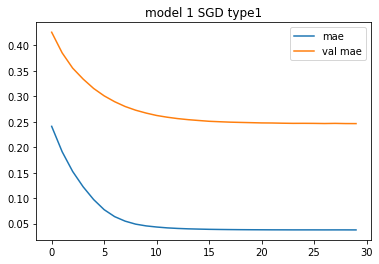

In [13]:
mae = history.history['mae']
val_mae = history.history['val_mae']
epoch = range(len(mae))

plt.title('model 1 SGD type1')
plt.plot(epoch, mae, label='mae')
plt.plot(epoch, val_mae, label='val mae')
plt.legend()
plt.show()

In [14]:
forecast = np.append(x_train, x_test)
forecast_date = np.append(y_train, y_test)
win_size= 400
test_telur_ = scal_range.fit_transform(forecast.reshape(-1, 1))

131/131 [==============================] - 4s 25ms/step
1122.1425 4.3330374 1566.40615741895


,date,actual,prediction
0,2021-05-20,26000,25484.324219
1,2021-05-21,26000,25486.109375
2,2021-05-24,25900,25489.175781
3,2021-05-25,25950,25488.433594
4,2021-05-27,26000,25492.583984
...,...,...,...
229,2022-11-02,24400,25497.396484
230,2022-11-03,25000,25522.853516
231,2022-11-04,25650,25501.037109
232,2022-12-01,28850,25520.052734


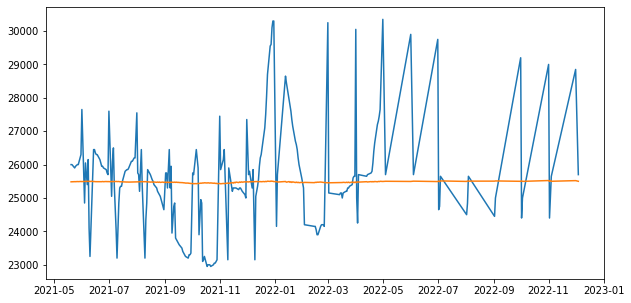

In [15]:
prediction = forecast_predict(model, test_telur_, time_size=win_size, batch_size=5)

data_result = prediction[(len(x_train))-win_size:-1, -1 ]
data_result = scal_range.inverse_transform(data_result.reshape(-1, 1))
data_result = data_result.reshape(-1)
mae= tf.keras.metrics.mean_absolute_error(x_test, data_result)
mape = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result)
mse = tf.keras.metrics.mean_squared_error(x_test, data_result)

rmse =math.sqrt(mse.numpy())
print(mae.numpy(), mape.numpy(), rmse)

data_new_telur = pd.DataFrame()
data_new_telur['date'] = y_test
data_new_telur['actual'] = x_test
data_new_telur['prediction'] = data_result
data_new_telur.to_csv('telur_model1_sgd_type1.csv')

plt.figure(figsize=(10, 5))
plt.plot(data_new_telur.date, data_new_telur.actual)
plt.plot(data_new_telur.date, data_new_telur.prediction)
data_new_telur

#### type2

In [16]:
history_t1 = model.fit(train_step1, epochs=30, validation_data=val_step)

Epoch 1/30
718/718 [==============================] - 26s 36ms/step - loss: 0.0056 - mae: 0.0570 - mape: 37.1382 - val_loss: 0.0793 - val_mae: 0.2583 - val_mape: 5879231.0000
Epoch 2/30
718/718 [==============================] - 27s 37ms/step - loss: 0.0055 - mae: 0.0564 - mape: 35.9355 - val_loss: 0.0801 - val_mae: 0.2597 - val_mape: 5832989.0000
Epoch 3/30
718/718 [==============================] - 27s 38ms/step - loss: 0.0054 - mae: 0.0561 - mape: 35.4581 - val_loss: 0.0786 - val_mae: 0.2570 - val_mape: 5928955.0000
Epoch 4/30
718/718 [==============================] - 27s 38ms/step - loss: 0.0054 - mae: 0.0565 - mape: 35.7591 - val_loss: 0.0788 - val_mae: 0.2574 - val_mape: 5914303.0000
Epoch 5/30
718/718 [==============================] - 27s 37ms/step - loss: 0.0055 - mae: 0.0564 - mape: 35.9412 - val_loss: 0.0796 - val_mae: 0.2587 - val_mape: 5870055.5000
Epoch 6/30
718/718 [==============================] - 27s 38ms/step - loss: 0.0054 - mae: 0.0561 - mape: 35.6278 - val_loss: 

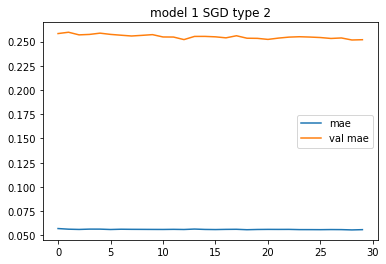

In [17]:
mae_t1 = history_t1.history['mae']
val_mae_t1 = history_t1.history['val_mae']
epoch_t1 = range(len(mae_t1))

plt.title('model 1 SGD type 2')
plt.plot(epoch_t1, mae_t1, label='mae')
plt.plot(epoch_t1, val_mae_t1, label='val mae')
plt.legend()
plt.show()

199/199 [==============================] - 1s 7ms/step
1137.5999 4.355716 1587.6762894242643


,date,actual,prediction
0,2021-05-20,26000,25484.324219
1,2021-05-21,26000,25486.109375
2,2021-05-24,25900,25489.175781
3,2021-05-25,25950,25488.433594
4,2021-05-27,26000,25492.583984
...,...,...,...
229,2022-11-02,24400,25497.396484
230,2022-11-03,25000,25522.853516
231,2022-11-04,25650,25501.037109
232,2022-12-01,28850,25520.052734


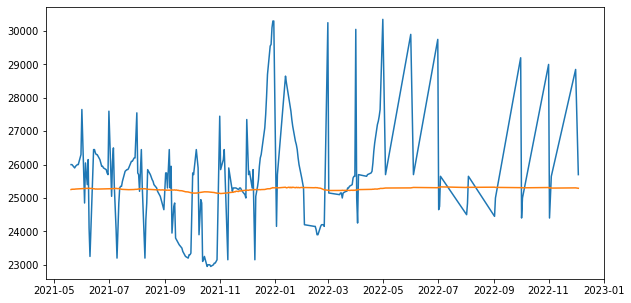

In [18]:
win_size1 = 60
test_telur_1 = scal_range.fit_transform(forecast.reshape(-1, 1))
prediction_1 = forecast_predict(model, test_telur_1, time_size=win_size1, batch_size=5)

data_result_1 = prediction_1[(len(x_train))-win_size1:-1, -1 ]
data_result_1 = scal_range.inverse_transform(data_result_1.reshape(-1, 1))
data_result_1 = data_result_1.reshape(-1)
mae_1= tf.keras.metrics.mean_absolute_error(x_test, data_result_1)
mape_1 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result_1)
mse_1 = tf.keras.metrics.mean_squared_error(x_test, data_result_1)
rmse_1 =math.sqrt(mse_1.numpy())
print(mae_1.numpy(), mape_1.numpy(), rmse_1)

data_new_telur_1 = pd.DataFrame()
data_new_telur_1['actual'] = x_test
data_new_telur_1['prediction'] = data_result_1
data_new_telur_1.to_csv('telur_model1_sgd_type2.csv')

plt.figure(figsize=(10, 5))
plt.plot(y_test, data_new_telur_1.actual)
plt.plot(y_test, data_new_telur_1.prediction)
data_new_telur

#### type3

In [19]:
history_t2 = model.fit(train_step2, epochs=30, validation_data=val_step)

Epoch 1/30
84/84 [==============================] - 11s 129ms/step - loss: 0.0046 - mae: 0.0486 - mape: 25.9627 - val_loss: 0.0766 - val_mae: 0.2533 - val_mape: 6091230.0000
Epoch 2/30
84/84 [==============================] - 11s 135ms/step - loss: 0.0046 - mae: 0.0484 - mape: 25.5750 - val_loss: 0.0773 - val_mae: 0.2547 - val_mape: 6044008.0000
Epoch 3/30
84/84 [==============================] - 11s 131ms/step - loss: 0.0045 - mae: 0.0483 - mape: 25.4112 - val_loss: 0.0777 - val_mae: 0.2553 - val_mape: 6022571.0000
Epoch 4/30
84/84 [==============================] - 11s 133ms/step - loss: 0.0045 - mae: 0.0482 - mape: 25.1701 - val_loss: 0.0780 - val_mae: 0.2559 - val_mape: 6000758.0000
Epoch 5/30
84/84 [==============================] - 11s 131ms/step - loss: 0.0045 - mae: 0.0482 - mape: 25.2044 - val_loss: 0.0781 - val_mae: 0.2560 - val_mape: 5998073.0000
Epoch 6/30
84/84 [==============================] - 11s 135ms/step - loss: 0.0045 - mae: 0.0482 - mape: 25.1987 - val_loss: 0.0780

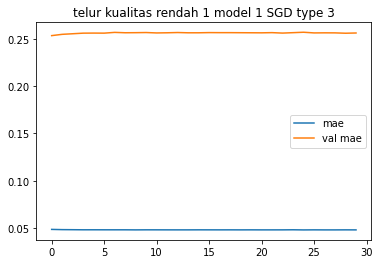

In [20]:
mae_t2 = history_t2.history['mae']
val_mae_t2 = history_t2.history['val_mae']
epoch_t2 = range(len(mae_t2))

plt.title('telur kualitas rendah 1 model 1 SGD type 3')
plt.plot(epoch_t2, mae_t2, label='mae')
plt.plot(epoch_t2, val_mae_t2, label='val mae')
plt.legend()
plt.show()

181/181 [==============================] - 2s 12ms/step
1163.5911 4.4419646 1609.3094792487864


,actual,prediction
0,26000,25155.656250
1,26000,25163.244141
2,25900,25165.691406
3,25950,25170.152344
4,26000,25173.478516
...,...,...
229,24400,25198.978516
230,25000,25215.650391
231,25650,25199.642578
232,28850,25207.306641


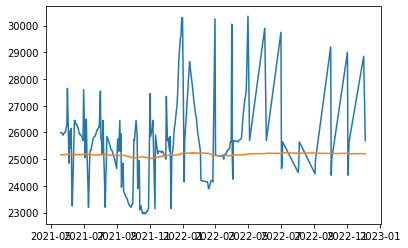

In [21]:
win_size2 = 150
prediction_2 = forecast_predict(model, test_telur_, time_size=win_size2, batch_size=5)

data_result_2 = prediction_2[(len(x_train))-win_size2:-1, -1 ]
data_result_2 = scal_range.inverse_transform(data_result_2.reshape(-1, 1))
data_result_2 = data_result_2.reshape(-1)
mae_2= tf.keras.metrics.mean_absolute_error(x_test, data_result_2)
mape_2 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result_2)
mse_2 = tf.keras.metrics.mean_squared_error(x_test, data_result_2)

rmse_2 =math.sqrt(mse_2.numpy())
print(mae_2.numpy(), mape_2.numpy(), rmse_2)

data_new_telur_2 = pd.DataFrame()
# data_new_telur1['date'] = date_test
data_new_telur_2['actual'] = x_test
data_new_telur_2['prediction'] = data_result_2
data_new_telur_2.to_csv('telur_model1_sgd_type3.csv')

plt.plot(y_test, data_new_telur_2.actual)
plt.plot(y_test, data_new_telur_2.prediction)
data_new_telur_2

### Adam

In [22]:
model_a= Sequential([
    Conv1D(16, kernel_size=2, activation='relu',padding='causal', strides=2, input_shape=[None, 1]),
        LSTM(24, return_sequences=True),
        LSTM(20),
        Dense(64, activation='relu'),
        Dense(1)
])

model_a.compile(loss= 'mean_squared_error', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), metrics=['mae', 'mape'])
model_a.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, None, 16)          48        
                                                                 
 lstm_2 (LSTM)               (None, None, 24)          3936      
                                                                 
 lstm_3 (LSTM)               (None, 20)                3600      
                                                                 
 dense_2 (Dense)             (None, 64)                1344      
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 8,993
Trainable params: 8,993
Non-trainable params: 0
_________________________________________________________________


#### Type 1

In [23]:
history_a = model_a.fit(train_step, epochs=30, validation_data=val_step)

Epoch 1/30
44/44 [==============================] - 14s 215ms/step - loss: 0.0599 - mae: 0.2398 - mape: 99.2964 - val_loss: 0.1979 - val_mae: 0.4107 - val_mape: 810098.8125
Epoch 2/30
44/44 [==============================] - 9s 196ms/step - loss: 0.0305 - mae: 0.1674 - mape: 68.2391 - val_loss: 0.1190 - val_mae: 0.3187 - val_mape: 3991562.0000
Epoch 3/30
44/44 [==============================] - 9s 198ms/step - loss: 0.0074 - mae: 0.0730 - mape: 28.8916 - val_loss: 0.0508 - val_mae: 0.2050 - val_mape: 8434229.0000
Epoch 4/30
44/44 [==============================] - 9s 200ms/step - loss: 0.0021 - mae: 0.0376 - mape: 17.2515 - val_loss: 0.0485 - val_mae: 0.2001 - val_mape: 8683594.0000
Epoch 5/30
44/44 [==============================] - 9s 201ms/step - loss: 0.0020 - mae: 0.0375 - mape: 17.1586 - val_loss: 0.0491 - val_mae: 0.2013 - val_mape: 8620445.0000
Epoch 6/30
44/44 [==============================] - 9s 194ms/step - loss: 0.0020 - mae: 0.0377 - mape: 17.2122 - val_loss: 0.0492 - val

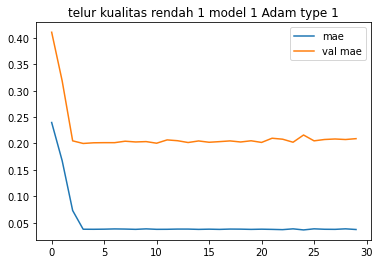

In [24]:
mae_a = history_a.history['mae']
val_mae_a = history_a.history['val_mae']
epoch_a = range(len(mae_a))

plt.title('telur kualitas rendah 1 model 1 Adam type 1')
plt.plot(epoch_a, mae_a, label='mae')
plt.plot(epoch_a, val_mae_a, label='val mae')
plt.legend()
plt.show()

131/131 [==============================] - 4s 25ms/step
1106.0265 4.265546 1524.137707033062


,actual,prediction
0,26000,25399.085938
1,26000,25415.742188
2,25900,25430.367188
3,25950,25441.623047
4,26000,25456.197266
...,...,...
229,24400,25663.085938
230,25000,25766.957031
231,25650,25651.042969
232,28850,25747.531250


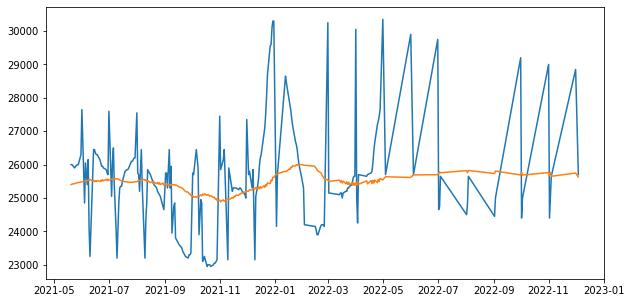

In [25]:
prediction_a = forecast_predict(model_a, test_telur_, time_size=win_size, batch_size=5)

data_result_a = prediction_a[(len(x_train))-win_size:-1, -1 ]
data_result_a = scal_range.inverse_transform(data_result_a.reshape(-1, 1))
data_result_a = data_result_a.reshape(-1)
mae_a= tf.keras.metrics.mean_absolute_error(x_test, data_result_a)
mape_a = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result_a)
mse_a = tf.keras.metrics.mean_squared_error(x_test, data_result_a)

rmse_a =math.sqrt(mse_a.numpy())
print(mae_a.numpy(), mape_a.numpy(), rmse_a)

data_new_telur_a = pd.DataFrame()
# data_new_telur1['date'] = date_test
data_new_telur_a['actual'] = x_test
data_new_telur_a['prediction'] = data_result_a
data_new_telur_a.to_csv('telur_model1_adam_type1.csv')

plt.figure(figsize=(10,5))
plt.plot(y_test, data_new_telur_a.actual)
plt.plot(y_test, data_new_telur_a.prediction)
data_new_telur_a

#### Type 2

In [26]:
history_a1 = model_a.fit(train_step1, epochs=30, validation_data=val_step)

Epoch 1/30
718/718 [==============================] - 27s 38ms/step - loss: 0.0050 - mae: 0.0537 - mape: 32.8581 - val_loss: 0.0575 - val_mae: 0.2169 - val_mape: 7959285.0000
Epoch 2/30
718/718 [==============================] - 27s 37ms/step - loss: 0.0049 - mae: 0.0525 - mape: 32.2426 - val_loss: 0.0528 - val_mae: 0.2076 - val_mape: 8506067.0000
Epoch 3/30
718/718 [==============================] - 30s 41ms/step - loss: 0.0048 - mae: 0.0526 - mape: 32.0047 - val_loss: 0.0493 - val_mae: 0.1998 - val_mape: 8939734.0000
Epoch 4/30
718/718 [==============================] - 28s 39ms/step - loss: 0.0048 - mae: 0.0524 - mape: 32.0311 - val_loss: 0.0528 - val_mae: 0.2067 - val_mape: 8628752.0000
Epoch 5/30
718/718 [==============================] - 28s 38ms/step - loss: 0.0048 - mae: 0.0520 - mape: 31.6375 - val_loss: 0.0449 - val_mae: 0.1876 - val_mape: 9712476.0000
Epoch 6/30
718/718 [==============================] - 27s 37ms/step - loss: 0.0048 - mae: 0.0513 - mape: 31.4696 - val_loss: 

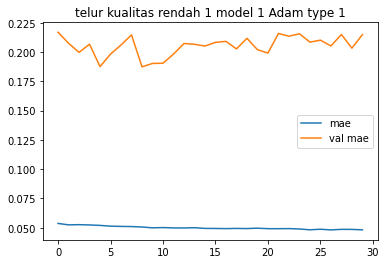

In [27]:
mae_a1 = history_a1.history['mae']
val_mae_a1 = history_a1.history['val_mae']
epoch_a1 = range(len(mae_a1))

plt.title('telur kualitas rendah 1 model 1 Adam type 1')
plt.plot(epoch_a1, mae_a1, label='mae')
plt.plot(epoch_a1, val_mae_a1, label='val mae')
plt.legend()
plt.show()

199/199 [==============================] - 1s 7ms/step
1060.5707 4.066425 1441.1609903130184


,actual,prediction
0,26000,25623.681641
1,26000,25576.234375
2,25900,25684.648438
3,25950,25645.179688
4,26000,25714.380859
...,...,...
229,24400,25243.195312
230,25000,25368.380859
231,25650,25156.226562
232,28850,25266.058594


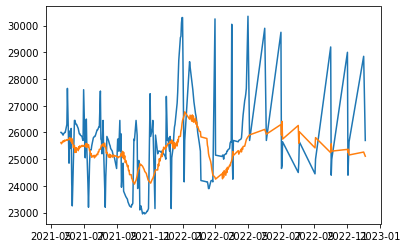

In [28]:
prediction_a1 = forecast_predict(model_a, test_telur_, time_size=win_size1, batch_size=5)

data_result_a1 = prediction_a1[(len(x_train))-win_size1:-1, -1 ]
data_result_a1 = scal_range.inverse_transform(data_result_a1.reshape(-1, 1))
data_result_a1 = data_result_a1.reshape(-1)
mae_a1= tf.keras.metrics.mean_absolute_error(x_test, data_result_a1)
mape_a1 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result_a1)
mse_a1 = tf.keras.metrics.mean_squared_error(x_test, data_result_a1)

rmse_a1 =math.sqrt(mse_a1.numpy())
print(mae_a1.numpy(), mape_a1.numpy(), rmse_a1)

data_new_telur_a1 = pd.DataFrame()
data_new_telur_a1['actual'] = x_test
data_new_telur_a1['prediction'] = data_result_a1
data_new_telur_a1.to_csv('telur_model1_adam_type2.csv')

plt.plot(y_test, data_new_telur_a1.actual)
plt.plot(y_test, data_new_telur_a1.prediction)
data_new_telur_a1

#### Type 3

In [29]:
history_a2 = model_a.fit(train_step2, epochs=30, validation_data=val_step)

Epoch 1/30
84/84 [==============================] - 11s 132ms/step - loss: 0.0038 - mae: 0.0406 - mape: 20.8608 - val_loss: 0.0566 - val_mae: 0.2111 - val_mape: 8432455.0000
Epoch 2/30
84/84 [==============================] - 12s 136ms/step - loss: 0.0037 - mae: 0.0404 - mape: 20.6928 - val_loss: 0.0569 - val_mae: 0.2119 - val_mape: 8409482.0000
Epoch 3/30
84/84 [==============================] - 11s 134ms/step - loss: 0.0037 - mae: 0.0403 - mape: 20.3279 - val_loss: 0.0562 - val_mae: 0.2101 - val_mape: 8494580.0000
Epoch 4/30
84/84 [==============================] - 11s 130ms/step - loss: 0.0038 - mae: 0.0406 - mape: 20.8910 - val_loss: 0.0536 - val_mae: 0.2032 - val_mape: 8809804.0000
Epoch 5/30
84/84 [==============================] - 11s 132ms/step - loss: 0.0037 - mae: 0.0400 - mape: 20.1730 - val_loss: 0.0535 - val_mae: 0.2029 - val_mape: 8828640.0000
Epoch 6/30
84/84 [==============================] - 11s 131ms/step - loss: 0.0037 - mae: 0.0401 - mape: 20.4140 - val_loss: 0.0527

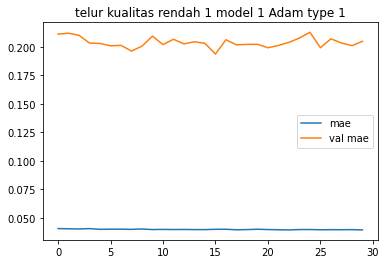

In [30]:
mae_a2 = history_a2.history['mae']
val_mae_a2 = history_a2.history['val_mae']
epoch_a2 = range(len(mae_a2))

plt.title('telur kualitas rendah 1 model 1 Adam type 1')
plt.plot(epoch_a2, mae_a2, label='mae')
plt.plot(epoch_a2, val_mae_a2, label='val mae')
plt.legend()
plt.show()

181/181 [==============================] - 2s 13ms/step
1043.5068 4.0036583 1423.6646374761158


,actual,prediction
0,26000,25762.546875
1,26000,25734.894531
2,25900,25839.082031
3,25950,25820.193359
4,26000,25874.777344
...,...,...
229,24400,25331.623047
230,25000,25443.130859
231,25650,25197.574219
232,28850,25338.646484


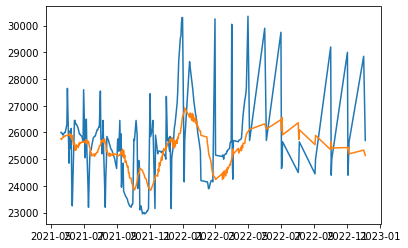

In [31]:
prediction_a2 = forecast_predict(model_a, test_telur_, time_size=win_size2, batch_size=5)

data_result_a2 = prediction_a2[(len(x_train))-win_size2:-1, -1 ]
data_result_a2 = scal_range.inverse_transform(data_result_a2.reshape(-1, 1))
data_result_a2 = data_result_a2.reshape(-1)
mae_a2= tf.keras.metrics.mean_absolute_error(x_test, data_result_a2)
mape_a2 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result_a2)
mse_a2 = tf.keras.metrics.mean_squared_error(x_test, data_result_a2)

rmse_a2 =math.sqrt(mse_a2.numpy())
print(mae_a2.numpy(), mape_a2.numpy(), rmse_a2)

data_new_telur_a2 = pd.DataFrame()
# data_new_telur1['date'] = date_test
data_new_telur_a2['actual'] = x_test
data_new_telur_a2['prediction'] = data_result_a2
data_new_telur_a2.to_csv('telur_model1_adam_type3.csv')

plt.plot(y_test, data_new_telur_a2.actual)
plt.plot(y_test, data_new_telur_a2.prediction)
data_new_telur_a2

## model 1

### Adam

In [32]:
model1= Sequential([
    Conv1D(16, kernel_size=5, activation='relu', strides=2, input_shape=[None, 1], padding='causal'),
        LSTM(128, return_sequences=True),
        LSTM(32),
        Dense(64, activation='relu'),
        Dense(128, activation='relu'),
        Dense(1)
])

model1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss='mse', metrics=['mae', 'mape'])
model1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, None, 16)          96        
                                                                 
 lstm_4 (LSTM)               (None, None, 128)         74240     
                                                                 
 lstm_5 (LSTM)               (None, 32)                20608     
                                                                 
 dense_4 (Dense)             (None, 64)                2112      
                                                                 
 dense_5 (Dense)             (None, 128)               8320      
                                                                 
 dense_6 (Dense)             (None, 1)                 129       
                                                                 
Total params: 105,505
Trainable params: 105,505
Non-tr

#### Type 1

In [33]:
history1 = model1.fit(train_step, epochs=100, validation_data=val_step)

Epoch 1/100
44/44 [==============================] - 22s 343ms/step - loss: 0.0076 - mae: 0.0624 - mape: 27.1131 - val_loss: 0.0575 - val_mae: 0.2179 - val_mape: 7812849.5000
Epoch 2/100
44/44 [==============================] - 14s 312ms/step - loss: 0.0023 - mae: 0.0402 - mape: 18.0888 - val_loss: 0.0527 - val_mae: 0.2088 - val_mape: 8243675.5000
Epoch 3/100
44/44 [==============================] - 14s 321ms/step - loss: 0.0022 - mae: 0.0393 - mape: 17.7759 - val_loss: 0.0536 - val_mae: 0.2104 - val_mape: 8162357.0000
Epoch 4/100
44/44 [==============================] - 15s 335ms/step - loss: 0.0023 - mae: 0.0402 - mape: 18.3108 - val_loss: 0.0711 - val_mae: 0.2424 - val_mape: 6745589.0000
Epoch 5/100
44/44 [==============================] - 14s 311ms/step - loss: 0.0022 - mae: 0.0400 - mape: 18.0321 - val_loss: 0.0666 - val_mae: 0.2338 - val_mape: 7060130.5000
Epoch 6/100
44/44 [==============================] - 14s 310ms/step - loss: 0.0021 - mae: 0.0374 - mape: 17.0091 - val_loss: 

17/17 [==============================] - 0s 16ms/step - loss: 0.0817 - mae: 0.2148 - mape: 49.1150


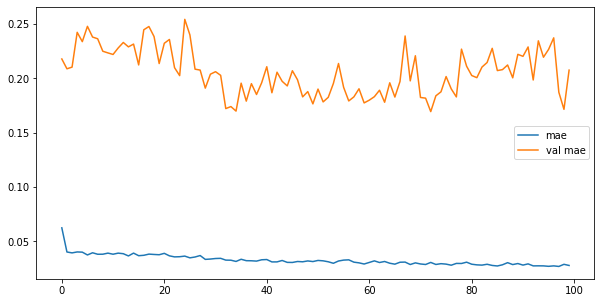

In [34]:
model1.evaluate(test_step)
mae1 = history1.history['mae']
val_mae1 = history1.history['val_mae']
epoch1 = range(len(mae1))

plt.figure(figsize=(10, 5))
plt.plot(epoch1, mae1, label='mae')
plt.plot(epoch1, val_mae1, label='val mae')
plt.legend()
plt.show()

In [35]:
prediction1 = forecast_predict(model1, test_telur_, time_size=win_size, batch_size=5)

data_result1 = prediction1[(len(x_train))-win_size:-1, -1 ]
data_result1 = scal_range.inverse_transform(data_result1.reshape(-1, 1))
data_result1 = data_result1.reshape(-1)
mae1 = tf.keras.metrics.mean_absolute_error(x_test, data_result1)
mape1 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result1)
mse1 = tf.keras.metrics.mean_squared_error(x_test, data_result1)

rmse1 = math.sqrt(mse1.numpy())
print(mae1.numpy(), mape1.numpy(), rmse1)

data_new_telur1 = pd.DataFrame()
data_new_telur1['actual'] = x_test
data_new_telur1['prediction'] = data_result1
data_new_telur1.to_csv('telur_model2_adam_type1.csv')

data_new_telur1

131/131 [==============================] - 5s 33ms/step
1028.8483 3.945237 1399.7331442099955


,actual,prediction
0,26000,26134.466797
1,26000,26140.931641
2,25900,26096.917969
3,25950,25982.476562
4,26000,25810.197266
...,...,...
229,24400,25451.808594
230,25000,25011.898438
231,25650,26616.740234
232,28850,24712.123047


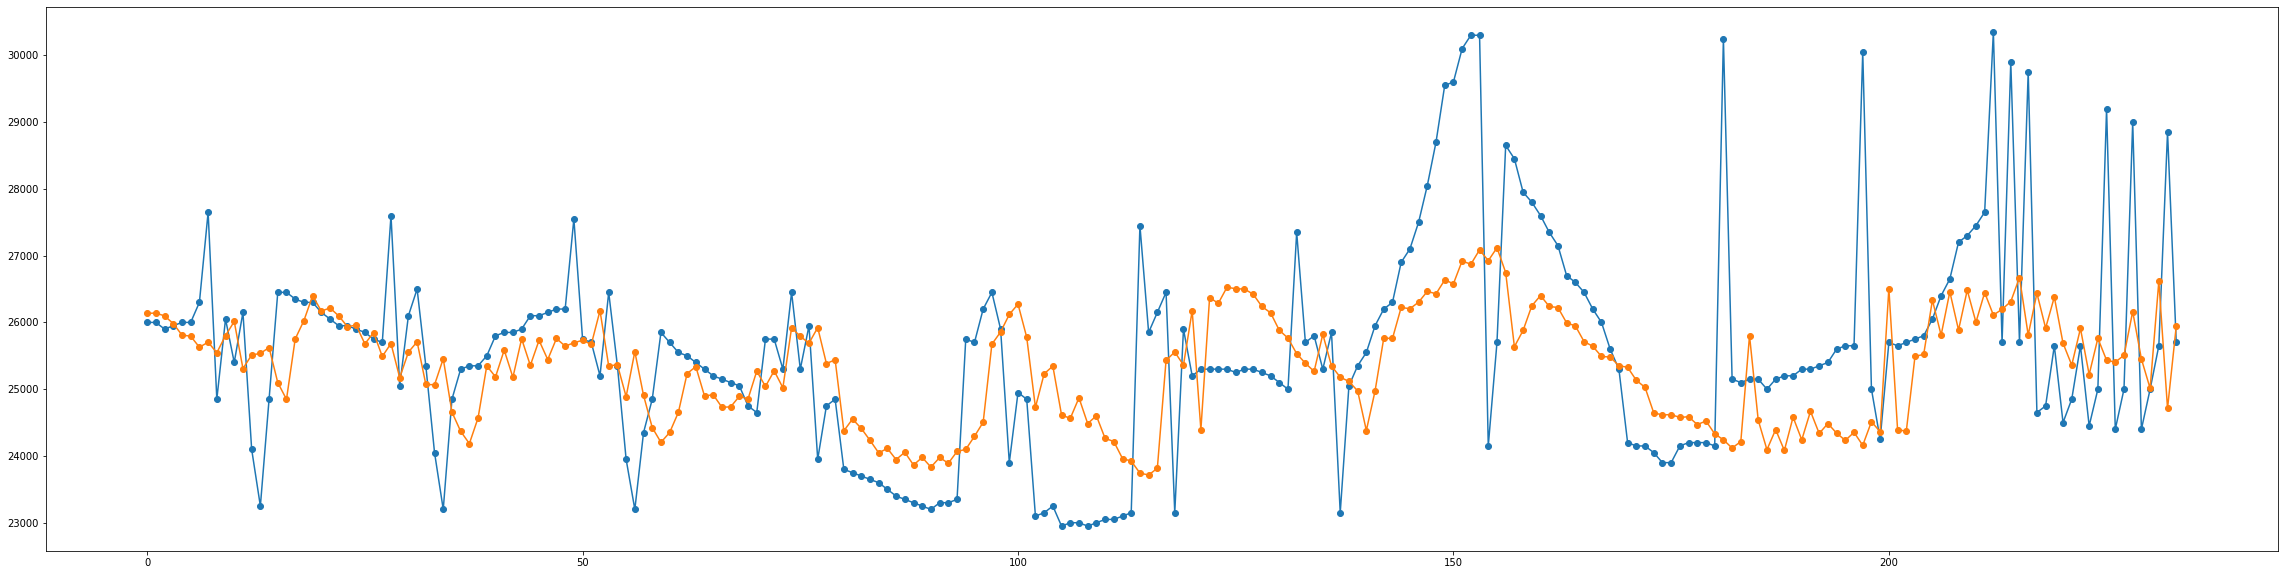

In [36]:
plt.figure(figsize=(40, 10))
plt.plot(range(len(x_test)), data_new_telur1['actual'], '-o')
plt.plot(range(len(x_test)), data_new_telur1['prediction'], '-o')

#### Type 2

In [37]:
history1_1 = model1.fit(train_step1, epochs=15, validation_data=val_step)

Epoch 1/15
718/718 [==============================] - 31s 43ms/step - loss: 0.0057 - mae: 0.0556 - mape: 33.6865 - val_loss: 0.0542 - val_mae: 0.2069 - val_mape: 8705638.0000
Epoch 2/15
718/718 [==============================] - 31s 43ms/step - loss: 0.0049 - mae: 0.0513 - mape: 31.4969 - val_loss: 0.0609 - val_mae: 0.2216 - val_mape: 7586918.0000
Epoch 3/15
718/718 [==============================] - 31s 43ms/step - loss: 0.0045 - mae: 0.0488 - mape: 29.4869 - val_loss: 0.0558 - val_mae: 0.2091 - val_mape: 7396340.0000
Epoch 4/15
718/718 [==============================] - 34s 48ms/step - loss: 0.0046 - mae: 0.0484 - mape: 29.6286 - val_loss: 0.0659 - val_mae: 0.2310 - val_mape: 7177992.0000
Epoch 5/15
718/718 [==============================] - 32s 45ms/step - loss: 0.0044 - mae: 0.0479 - mape: 28.5936 - val_loss: 0.0543 - val_mae: 0.2090 - val_mape: 7767026.0000
Epoch 6/15
718/718 [==============================] - 32s 45ms/step - loss: 0.0043 - mae: 0.0463 - mape: 27.9256 - val_loss: 

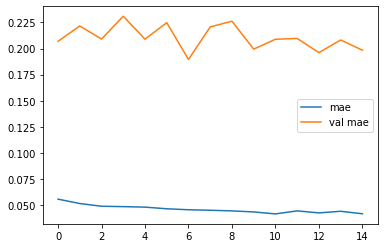

In [38]:
mae1_1 = history1_1.history['mae']
val_mae1_1 = history1_1.history['val_mae']
epoch1_1 = range(len(mae1_1))

plt.plot(epoch1_1, mae1_1, label='mae')
plt.plot(epoch1_1, val_mae1_1, label='val mae')
plt.legend()
plt.show()

199/199 [==============================] - 2s 12ms/step
973.2772 3.7932582 1399.7331442099955


,actual,prediction
0,26000,26234.275391
1,26000,26358.863281
2,25900,26248.529297
3,25950,26200.955078
4,26000,26036.429688
...,...,...
229,24400,25746.228516
230,25000,25916.238281
231,25650,25813.859375
232,28850,25773.833984


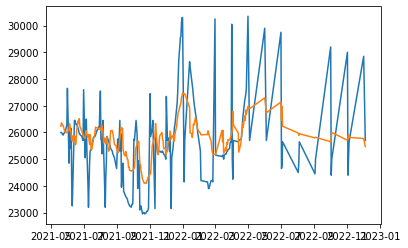

In [39]:
prediction1_1 = forecast_predict(model1, test_telur_, time_size=win_size1, batch_size=5)

data_result1_1 = prediction1_1[(len(x_train))-win_size1:-1, -1 ]
data_result1_1 = scal_range.inverse_transform(data_result1_1.reshape(-1, 1))
data_result1_1 = data_result1_1.reshape(-1)
mae1_1 = tf.keras.metrics.mean_absolute_error(x_test, data_result1_1)
mape1_1 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result1_1)
mse1_1 = tf.keras.metrics.mean_squared_error(x_test, data_result1_1)

rmse1_1 = math.sqrt(mse1.numpy())
print(mae1_1.numpy(), mape1_1.numpy(), rmse1_1)

data_new_telur1_1 = pd.DataFrame()
data_new_telur1_1['actual'] = x_test
data_new_telur1_1['prediction'] = data_result1_1
data_new_telur1_1.to_csv('telur_model2_adam_type2.csv')

plt.plot(y_test, data_new_telur1_1.actual)
plt.plot(y_test, data_new_telur1_1.prediction)
data_new_telur1_1

#### Type 3

In [40]:
history1_2 = model1.fit(train_step2, epochs=15, validation_data=val_step)

Epoch 1/15
84/84 [==============================] - 18s 213ms/step - loss: 0.0035 - mae: 0.0365 - mape: 18.9040 - val_loss: 0.0588 - val_mae: 0.2170 - val_mape: 6180477.5000
Epoch 2/15
84/84 [==============================] - 18s 213ms/step - loss: 0.0033 - mae: 0.0343 - mape: 17.2531 - val_loss: 0.0565 - val_mae: 0.2139 - val_mape: 6335484.0000
Epoch 3/15
84/84 [==============================] - 18s 210ms/step - loss: 0.0032 - mae: 0.0342 - mape: 17.3193 - val_loss: 0.0597 - val_mae: 0.2189 - val_mape: 5815221.0000
Epoch 4/15
84/84 [==============================] - 18s 211ms/step - loss: 0.0031 - mae: 0.0332 - mape: 16.5466 - val_loss: 0.0663 - val_mae: 0.2317 - val_mape: 5292821.0000
Epoch 5/15
84/84 [==============================] - 18s 209ms/step - loss: 0.0031 - mae: 0.0333 - mape: 16.5255 - val_loss: 0.0608 - val_mae: 0.2210 - val_mape: 5544950.0000
Epoch 6/15
84/84 [==============================] - 18s 213ms/step - loss: 0.0030 - mae: 0.0324 - mape: 15.9757 - val_loss: 0.0582

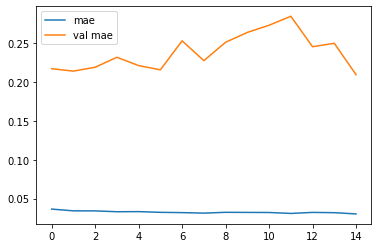

In [41]:
mae1_2 = history1_2.history['mae']
val_mae1_2 = history1_2.history['val_mae']
epoch1_2 = range(len(mae1_2))

plt.plot(epoch1_2, mae1_2, label='mae')
plt.plot(epoch1_2, val_mae1_2, label='val mae')
plt.legend()
plt.show()

181/181 [==============================] - 3s 16ms/step
1026.5868 3.9377146 1399.7331442099955


,actual,prediction
0,26000,26055.226562
1,26000,26114.550781
2,25900,26032.431641
3,25950,25910.445312
4,26000,25813.039062
...,...,...
229,24400,25549.351562
230,25000,26011.554688
231,25650,25852.505859
232,28850,25559.138672


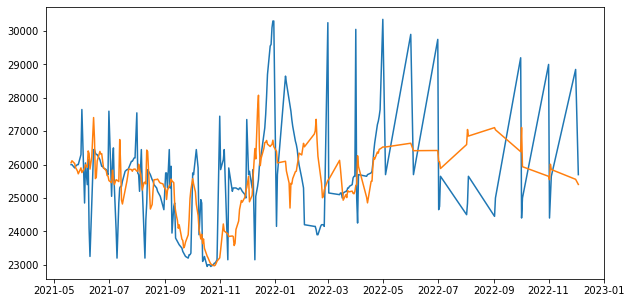

In [42]:
prediction1_2 = forecast_predict(model1, test_telur_, time_size=win_size2, batch_size=5)

data_result1_2 = prediction1_2[(len(x_train))-win_size2:-1, -1 ]
data_result1_2 = scal_range.inverse_transform(data_result1_2.reshape(-1, 1))
data_result1_2 = data_result1_2.reshape(-1)
mae1_2 = tf.keras.metrics.mean_absolute_error(x_test, data_result1_2)
mape1_2 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result1_2)
mse1_2 = tf.keras.metrics.mean_squared_error(x_test, data_result1_2)
rmse1_2 = math.sqrt(mse1.numpy())
print(mae1_2.numpy(), mape1_2.numpy(), rmse1_2)

data_new_telur1_2 = pd.DataFrame()
data_new_telur1_2['actual'] = x_test
data_new_telur1_2['prediction'] = data_result1_2
data_new_telur1_2.to_csv('telur_model2_adam_type3.csv')

plt.figure(figsize=(10, 5))
plt.plot(y_test, data_new_telur1_2.actual)
plt.plot(y_test, data_new_telur1_2.prediction)

data_new_telur1_2

### SGD

In [43]:
model1_a= Sequential([
    # tf.keras.layers.Conv1D(97, kernel_size=5, 
    #                                        activation='relu',strides=2,
    #                                        input_shape=[None, 1]),
    #                 LSTM(24, return_sequences=True),
    #                 LSTM(64),
    #                 Dense(50, activation='relu'),
    #                 Dense(12, activation='relu'),
    #                 Dense(1)
    Conv1D(16, kernel_size=5, activation='relu', strides=2, input_shape=[None, 1], padding='causal'),
        LSTM(128, return_sequences=True),
        LSTM(32),
        Dense(64, activation='relu'),
        Dense(128, activation='relu'),
        Dense(1)
])

model1_a.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=1e-4, momentum=0.8), loss='mse', metrics=['mae', 'mape'])
model1_a.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, None, 16)          96        
                                                                 
 lstm_6 (LSTM)               (None, None, 128)         74240     
                                                                 
 lstm_7 (LSTM)               (None, 32)                20608     
                                                                 
 dense_7 (Dense)             (None, 64)                2112      
                                                                 
 dense_8 (Dense)             (None, 128)               8320      
                                                                 
 dense_9 (Dense)             (None, 1)                 129       
                                                                 
Total params: 105,505
Trainable params: 105,505
Non-tr

In [44]:
# plot_model(model1, to_file='model2_plot.png', show_shapes=True, show_layer_names=True)

#### Type1 

In [45]:
history1_a = model1_a.fit(train_step, epochs=15, validation_data=val_step)

Epoch 1/15
44/44 [==============================] - 19s 346ms/step - loss: 0.0587 - mae: 0.2379 - mape: 98.5050 - val_loss: 0.2169 - val_mae: 0.4309 - val_mape: 266324.2500
Epoch 2/15
44/44 [==============================] - 14s 319ms/step - loss: 0.0480 - mae: 0.2142 - mape: 88.3217 - val_loss: 0.1987 - val_mae: 0.4116 - val_mape: 851287.1875
Epoch 3/15
44/44 [==============================] - 14s 320ms/step - loss: 0.0400 - mae: 0.1947 - mape: 79.8605 - val_loss: 0.1838 - val_mae: 0.3950 - val_mape: 1351130.0000
Epoch 4/15
44/44 [==============================] - 14s 315ms/step - loss: 0.0338 - mae: 0.1783 - mape: 72.8284 - val_loss: 0.1715 - val_mae: 0.3814 - val_mape: 1788745.1250
Epoch 5/15
44/44 [==============================] - 14s 317ms/step - loss: 0.0288 - mae: 0.1636 - mape: 66.5430 - val_loss: 0.1610 - val_mae: 0.3694 - val_mape: 2177768.0000
Epoch 6/15
44/44 [==============================] - 14s 317ms/step - loss: 0.0247 - mae: 0.1504 - mape: 60.7960 - val_loss: 0.1519 -

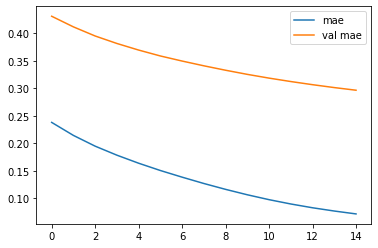

In [46]:
mae1_a = history1_a.history['mae']
val_mae1_a = history1_a.history['val_mae']
epoch1_a = range(len(mae1_a))

plt.plot(epoch1_a, mae1_a, label='mae')
plt.plot(epoch1_a, val_mae1_a, label='val mae')
plt.legend()
plt.show()

131/131 [==============================] - 4s 34ms/step
1026.6235 3.9378552 1447.7824422198246


,actual,prediction
0,26000,26055.275391
1,26000,26114.601562
2,25900,26032.546875
3,25950,25910.546875
4,26000,25812.984375
...,...,...
229,24400,25549.347656
230,25000,26011.578125
231,25650,25852.519531
232,28850,25559.140625


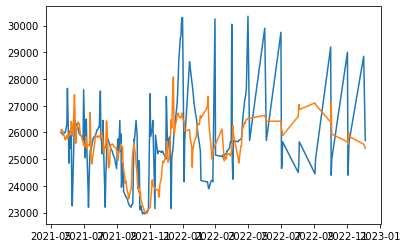

In [47]:
prediction1_a = forecast_predict(model1, test_telur_, time_size=win_size, batch_size=5)

data_result1_a = prediction1_a[(len(x_train))-win_size:-1, -1 ]
data_result1_a = scal_range.inverse_transform(data_result1_a.reshape(-1, 1))
data_result1_a = data_result1_a.reshape(-1)
mae1_a = tf.keras.metrics.mean_absolute_error(x_test, data_result1_a)
mape1_a = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result1_a)
mse1_a = tf.keras.metrics.mean_squared_error(x_test, data_result1_a)

rmse1_a = math.sqrt(mse1_a.numpy())
print(mae1_a.numpy(), mape1_a.numpy(), rmse1_a)

data_new_telur1_a = pd.DataFrame()
data_new_telur1_a['actual'] = x_test
data_new_telur1_a['prediction'] = data_result1_a
data_new_telur1_a.to_csv('telur_model2_sgd_type1.csv')

plt.plot(y_test, data_new_telur1_a.actual)
plt.plot(y_test, data_new_telur1_a.prediction)

data_new_telur1_a

#### Type 2


In [48]:
history1_a1 = model1_a.fit(train_step1, epochs=15, validation_data=val_step)

Epoch 1/15
718/718 [==============================] - 31s 43ms/step - loss: 0.0057 - mae: 0.0586 - mape: 32.6155 - val_loss: 0.0875 - val_mae: 0.2721 - val_mape: 5518829.5000
Epoch 2/15
718/718 [==============================] - 31s 43ms/step - loss: 0.0054 - mae: 0.0566 - mape: 34.8484 - val_loss: 0.0838 - val_mae: 0.2659 - val_mape: 5739629.0000
Epoch 3/15
718/718 [==============================] - 31s 43ms/step - loss: 0.0054 - mae: 0.0563 - mape: 35.3204 - val_loss: 0.0825 - val_mae: 0.2636 - val_mape: 5819310.5000
Epoch 4/15
718/718 [==============================] - 31s 43ms/step - loss: 0.0054 - mae: 0.0563 - mape: 35.6217 - val_loss: 0.0821 - val_mae: 0.2629 - val_mape: 5844817.0000
Epoch 5/15
718/718 [==============================] - 31s 43ms/step - loss: 0.0054 - mae: 0.0563 - mape: 35.7021 - val_loss: 0.0819 - val_mae: 0.2625 - val_mape: 5859708.0000
Epoch 6/15
718/718 [==============================] - 31s 43ms/step - loss: 0.0054 - mae: 0.0561 - mape: 35.5161 - val_loss: 

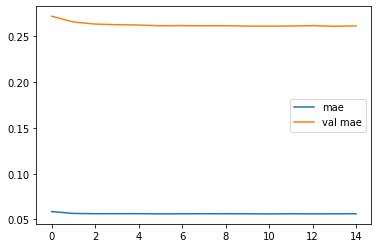

In [49]:
mae1_a1 = history1_a1.history['mae']
val_mae1_a1 = history1_a1.history['val_mae']
epoch1_a1 = range(len(mae1_a1))

plt.plot(epoch1_a1, mae1_a1, label='mae')
plt.plot(epoch1_a1, val_mae1_a1, label='val mae')
plt.legend()
plt.show()

199/199 [==============================] - 3s 9ms/step
1199.8046 4.568837 1646.742542111547


,actual,prediction
0,26000,25050.175781
1,26000,25052.068359
2,25900,25057.291016
3,25950,25055.753906
4,26000,25063.710938
...,...,...
229,24400,25105.599609
230,25000,25116.671875
231,25650,25103.953125
232,28850,25118.474609


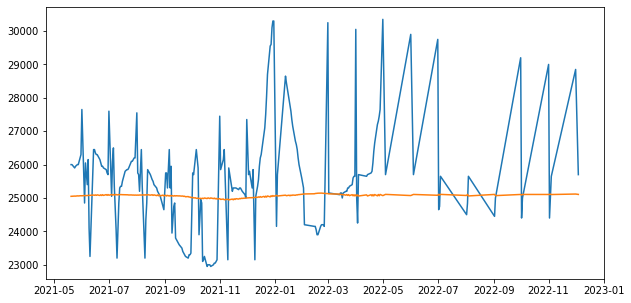

In [50]:
prediction1_a1 = forecast_predict(model1_a, test_telur_, time_size=win_size1, batch_size=5)

data_result1_a1 = prediction1_a1[(len(x_train))-win_size1:-1, -1 ]
data_result1_a1 = scal_range.inverse_transform(data_result1_a1.reshape(-1, 1))
data_result1_a1 = data_result1_a1.reshape(-1)
mae1_a1 = tf.keras.metrics.mean_absolute_error(x_test, data_result1_a1)
mape1_a1 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result1_a1)
mse1_a1 = tf.keras.metrics.mean_squared_error(x_test, data_result1_a1)

rmse1_a1 = math.sqrt(mse1_a1.numpy())
print(mae1_a1.numpy(), mape1_a1.numpy(), rmse1_a1)

data_new_telur1_a1 = pd.DataFrame()
data_new_telur1_a1['actual'] = x_test
data_new_telur1_a1['prediction'] = data_result1_a1
data_new_telur1_a1.to_csv('telur_model2_sgd_type2.csv')

plt.figure(figsize=(10, 5))
plt.plot(y_test, data_new_telur1_a1.actual)
plt.plot(y_test, data_new_telur1_a1.prediction)
data_new_telur1_a1

#### Type 3

In [51]:
history1_a2 = model1_a.fit(train_step2, epochs=15, validation_data=val_step)

Epoch 1/15
84/84 [==============================] - 18s 213ms/step - loss: 0.0046 - mae: 0.0482 - mape: 24.7731 - val_loss: 0.0811 - val_mae: 0.2611 - val_mape: 5912075.0000
Epoch 2/15
84/84 [==============================] - 18s 214ms/step - loss: 0.0046 - mae: 0.0482 - mape: 24.7539 - val_loss: 0.0808 - val_mae: 0.2607 - val_mape: 5927066.5000
Epoch 3/15
84/84 [==============================] - 18s 213ms/step - loss: 0.0046 - mae: 0.0482 - mape: 24.8298 - val_loss: 0.0807 - val_mae: 0.2604 - val_mape: 5939804.0000
Epoch 4/15
84/84 [==============================] - 18s 215ms/step - loss: 0.0046 - mae: 0.0482 - mape: 24.9078 - val_loss: 0.0805 - val_mae: 0.2600 - val_mape: 5951832.0000
Epoch 5/15
84/84 [==============================] - 18s 213ms/step - loss: 0.0046 - mae: 0.0482 - mape: 24.8929 - val_loss: 0.0803 - val_mae: 0.2598 - val_mape: 5960058.5000
Epoch 6/15
84/84 [==============================] - 18s 210ms/step - loss: 0.0046 - mae: 0.0483 - mape: 24.9359 - val_loss: 0.0802

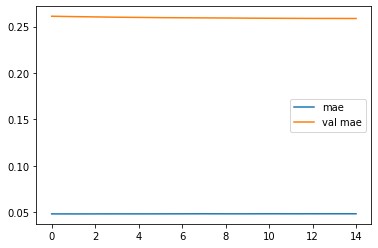

In [52]:
mae1_a2 = history1_a2.history['mae']
val_mae1_a2 = history1_a2.history['val_mae']
epoch1_a2 = range(len(mae1_a2))

plt.plot(epoch1_a2, mae1_a2, label='mae')
plt.plot(epoch1_a2, val_mae1_a2, label='val mae')
plt.legend()
plt.show()

181/181 [==============================] - 3s 17ms/step
1173.3148 4.477881 1622.8441853733216


,actual,prediction
0,26000,25136.564453
1,26000,25139.449219
2,25900,25144.669922
3,25950,25144.677734
4,26000,25152.498047
...,...,...
229,24400,25190.958984
230,25000,25187.468750
231,25650,25191.181641
232,28850,25188.304688


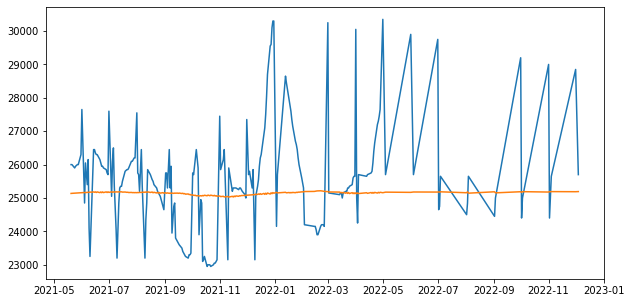

In [53]:
prediction1_a2 = forecast_predict(model1_a, test_telur_, time_size=win_size2, batch_size=5)

data_result1_a2 = prediction1_a2[(len(x_train))-win_size2:-1, -1 ]
data_result1_a2 = scal_range.inverse_transform(data_result1_a2.reshape(-1, 1))
data_result1_a2 = data_result1_a2.reshape(-1)
mae1_a2 = tf.keras.metrics.mean_absolute_error(x_test, data_result1_a2)
mape1_a2 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result1_a2)
mse1_a2 = tf.keras.metrics.mean_squared_error(x_test, data_result1_a2)

rmse1_a2 = math.sqrt(mse1_a2.numpy())
print(mae1_a2.numpy(), mape1_a2.numpy(), rmse1_a2)

data_new_telur1_a2 = pd.DataFrame()
data_new_telur1_a2['actual'] = x_test
data_new_telur1_a2['prediction'] = data_result1_a2
data_new_telur1_a2.to_csv('telur_model2_sgd_type3.csv')

plt.figure(figsize=(10, 5))
plt.plot(y_test, data_new_telur1_a2.actual)
plt.plot(y_test, data_new_telur1_a2.prediction)

data_new_telur1_a2

## model 2

### SGD

In [54]:
model2= Sequential([
    Conv1D(8, kernel_size=5, 
                            activation='relu',strides=2,
                            padding='causal', input_shape=[None, 1]),
    tf.keras.layers.MaxPool1D(2, padding="same"),
    LSTM(14, return_sequences=True),
    Dropout(0.3),
    LSTM(64),
    Dense(24, activation='relu'),
    Dense(550, activation='relu'),
    Dense(1)
])

model2.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=1e-7, momentum=0.9), loss='mean_squared_error', metrics=['mae'])
model2.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, None, 8)           48        
                                                                 
 max_pooling1d (MaxPooling1D  (None, None, 8)          0         
 )                                                               
                                                                 
 lstm_8 (LSTM)               (None, None, 14)          1288      
                                                                 
 dropout (Dropout)           (None, None, 14)          0         
                                                                 
 lstm_9 (LSTM)               (None, 64)                20224     
                                                                 
 dense_10 (Dense)            (None, 24)                1560      
                                                      

In [55]:
# plot_model(model2, to_file='model3_plot.png', show_shapes=True, show_layer_names=True)

#### Type 1

In [56]:
history2 = model2.fit(train_step, epochs=100, validation_data=val_step)

Epoch 1/100
44/44 [==============================] - 11s 144ms/step - loss: 0.0598 - mae: 0.2404 - val_loss: 0.2249 - val_mae: 0.4395
Epoch 2/100
44/44 [==============================] - 5s 120ms/step - loss: 0.0598 - mae: 0.2403 - val_loss: 0.2248 - val_mae: 0.4395
Epoch 3/100
44/44 [==============================] - 5s 118ms/step - loss: 0.0598 - mae: 0.2403 - val_loss: 0.2248 - val_mae: 0.4394
Epoch 4/100
44/44 [==============================] - 5s 117ms/step - loss: 0.0597 - mae: 0.2403 - val_loss: 0.2248 - val_mae: 0.4394
Epoch 5/100
44/44 [==============================] - 5s 115ms/step - loss: 0.0597 - mae: 0.2402 - val_loss: 0.2247 - val_mae: 0.4394
Epoch 6/100
44/44 [==============================] - 5s 117ms/step - loss: 0.0597 - mae: 0.2402 - val_loss: 0.2247 - val_mae: 0.4393
Epoch 7/100
44/44 [==============================] - 5s 116ms/step - loss: 0.0597 - mae: 0.2401 - val_loss: 0.2247 - val_mae: 0.4393
Epoch 8/100
44/44 [==============================] - 5s 116ms/step -

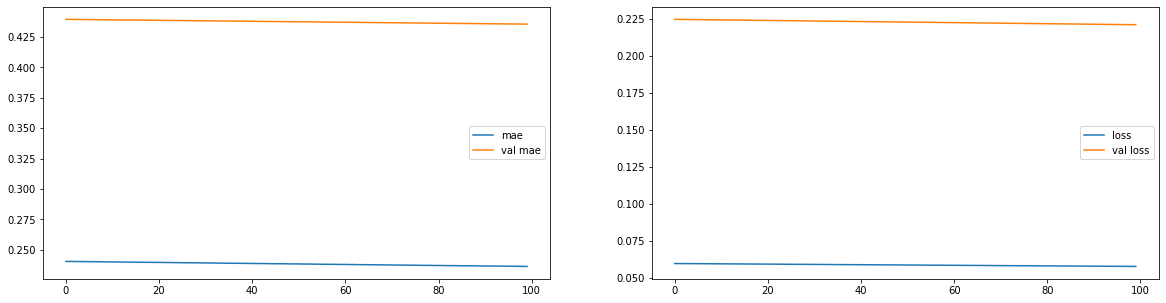

In [57]:
mae2 = history2.history['mae']
val_mae2 = history2.history['val_mae']
loss2 = history2.history['loss']
val_loss2 = history2.history['val_loss']
epoch2 = range(len(mae2))

plt.figure(figsize=(20, 5))
plt.subplot(1,2, 1)
plt.plot(epoch2, mae2, label='mae')
plt.plot(epoch2, val_mae2, label='val mae')
plt.legend()
plt.subplot(1,2,2)
plt.plot(epoch2, loss2, label='loss')
plt.plot(epoch2, val_loss2, label='val loss')
plt.legend()
plt.show()

131/131 [==============================] - 3s 16ms/step
3993.5002 15.307291 4291.179092044516


,actual,prediction
0,26000,21582.185547
1,26000,21583.009766
2,25900,21582.589844
3,25950,21582.916016
4,26000,21583.515625
...,...,...
229,24400,21578.812500
230,25000,21588.820312
231,25650,21578.740234
232,28850,21588.468750


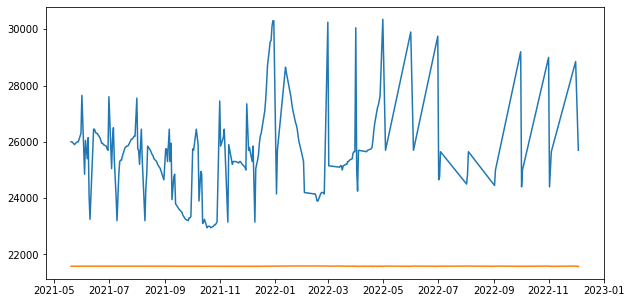

In [58]:
prediction2 = forecast_predict(model2, test_telur_, time_size=win_size, batch_size=5)

data_result2 = prediction2[(len(x_train))-win_size:-1, -1 ]
data_result2 = scal_range.inverse_transform(data_result2.reshape(-1, 1))
data_result2 = data_result2.reshape(-1)
mae2 = tf.keras.metrics.mean_absolute_error(x_test, data_result2)
mape2 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result2)
mse2 = tf.keras.metrics.mean_squared_error(x_test, data_result2)

rmse2 = math.sqrt(mse2.numpy())
print(mae2.numpy(), mape2.numpy(), rmse2)

data_new_telur2 = pd.DataFrame()
data_new_telur2['actual'] = x_test
data_new_telur2['prediction'] = data_result2
data_new_telur2.to_csv('telur_model3_sgd_type1.csv')

plt.figure(figsize=(10, 5))
plt.plot(y_test, data_new_telur2.actual)
plt.plot(y_test, data_new_telur2.prediction)
data_new_telur2

#### Type2

In [59]:
history2_1 = model2.fit(train_step1, epochs=50, validation_data=val_step)

Epoch 1/50
718/718 [==============================] - 16s 22ms/step - loss: 0.0461 - mae: 0.2015 - val_loss: 0.2207 - val_mae: 0.4350
Epoch 2/50
718/718 [==============================] - 15s 21ms/step - loss: 0.0459 - mae: 0.2010 - val_loss: 0.2202 - val_mae: 0.4345
Epoch 3/50
718/718 [==============================] - 15s 21ms/step - loss: 0.0457 - mae: 0.2004 - val_loss: 0.2197 - val_mae: 0.4339
Epoch 4/50
718/718 [==============================] - 15s 21ms/step - loss: 0.0455 - mae: 0.1998 - val_loss: 0.2192 - val_mae: 0.4334
Epoch 5/50
718/718 [==============================] - 16s 22ms/step - loss: 0.0452 - mae: 0.1993 - val_loss: 0.2187 - val_mae: 0.4329
Epoch 6/50
718/718 [==============================] - 15s 21ms/step - loss: 0.0450 - mae: 0.1987 - val_loss: 0.2183 - val_mae: 0.4323
Epoch 7/50
718/718 [==============================] - 15s 21ms/step - loss: 0.0448 - mae: 0.1982 - val_loss: 0.2178 - val_mae: 0.4318
Epoch 8/50
718/718 [==============================] - 15s 21ms

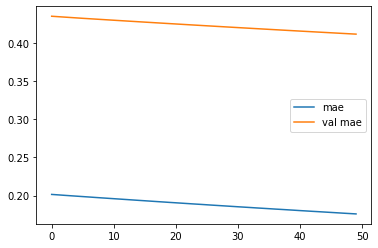

In [60]:
mae2_1 = history2_1.history['mae']
val_mae2_1 = history2_1.history['val_mae']
epoch2_1 = range(len(mae2_1))

plt.plot(epoch2_1, mae2_1, label='mae')
plt.plot(epoch2_1, val_mae2_1, label='val mae')
plt.legend()
plt.show()

In [61]:
prediction2_1 = forecast_predict(model2, test_telur_, time_size=win_size1, batch_size=5)

data_result2_1 = prediction2_1[(len(x_train))-win_size1:-1, -1 ]
data_result2_1 = scal_range.inverse_transform(data_result2_1.reshape(-1, 1))
data_result2_1 = data_result2_1.reshape(-1)
mae2_1 = tf.keras.metrics.mean_absolute_error(x_test, data_result2_1)
mape2_1 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result2_1)
mse2_1 = tf.keras.metrics.mean_squared_error(x_test, data_result2_1)

rmse2_1 = math.sqrt(mse2_1.numpy())
print(mae2_1.numpy(), mape2_1.numpy(), rmse2_1)

data_new_telur2_1 = pd.DataFrame()
data_new_telur2_1['actual'] = x_test
data_new_telur2_1['prediction'] = data_result2_1
data_new_telur2_1.to_csv('telur_model3_sgd_type2.csv')

data_new_telur2

199/199 [==============================] - 1s 5ms/step
3562.0747 13.614449 3892.812350987394


,actual,prediction
0,26000,21582.185547
1,26000,21583.009766
2,25900,21582.589844
3,25950,21582.916016
4,26000,21583.515625
...,...,...
229,24400,21578.812500
230,25000,21588.820312
231,25650,21578.740234
232,28850,21588.468750


#### Type 3

In [62]:
history2_2 = model2.fit(train_step2, epochs=50, validation_data=val_step)

Epoch 1/50
84/84 [==============================] - 7s 78ms/step - loss: 0.0403 - mae: 0.1888 - val_loss: 0.1987 - val_mae: 0.4115
Epoch 2/50
84/84 [==============================] - 7s 77ms/step - loss: 0.0403 - mae: 0.1887 - val_loss: 0.1986 - val_mae: 0.4115
Epoch 3/50
84/84 [==============================] - 7s 78ms/step - loss: 0.0402 - mae: 0.1886 - val_loss: 0.1985 - val_mae: 0.4114
Epoch 4/50
84/84 [==============================] - 7s 78ms/step - loss: 0.0402 - mae: 0.1886 - val_loss: 0.1985 - val_mae: 0.4114
Epoch 5/50
84/84 [==============================] - 7s 83ms/step - loss: 0.0402 - mae: 0.1885 - val_loss: 0.1984 - val_mae: 0.4113
Epoch 6/50
84/84 [==============================] - 7s 78ms/step - loss: 0.0402 - mae: 0.1885 - val_loss: 0.1984 - val_mae: 0.4113
Epoch 7/50
84/84 [==============================] - 7s 78ms/step - loss: 0.0402 - mae: 0.1884 - val_loss: 0.1983 - val_mae: 0.4112
Epoch 8/50
84/84 [==============================] - 7s 78ms/step - loss: 0.0401 - m

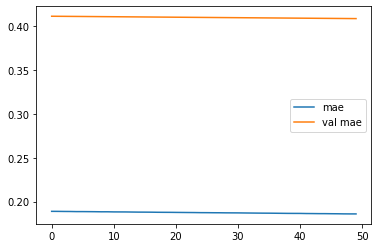

In [63]:
mae2_2 = history2_2.history['mae']
val_mae2_2 = history2_2.history['val_mae']
epoch2_2 = range(len(mae2_2))

plt.plot(epoch2_2, mae2_2, label='mae')
plt.plot(epoch2_2, val_mae2_2, label='val mae')
plt.legend()
plt.show()

In [64]:
prediction2_2 = forecast_predict(model2, test_telur_, time_size=win_size2, batch_size=5)

data_result2_2 = prediction2_2[(len(x_train))-win_size2:-1, -1 ]
data_result2_2 = scal_range.inverse_transform(data_result2_2.reshape(-1, 1))
data_result2_2 = data_result2_2.reshape(-1)
mae2_2 = tf.keras.metrics.mean_absolute_error(x_test, data_result2_2)
mape2_2 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result2_2)
mse2_2 = tf.keras.metrics.mean_squared_error(x_test, data_result2_2)

rmse2_2 = math.sqrt(mse2_2.numpy())
print(mae2_2.numpy(), mape2_2.numpy(), rmse2_2)

data_new_telur2_2 = pd.DataFrame()
data_new_telur2_2['actual'] = x_test
data_new_telur2_2['prediction'] = data_result2_2
data_new_telur2_2.to_csv('telur_model3_sgd_type3.csv')

data_new_telur2_2

181/181 [==============================] - 2s 9ms/step
3505.8472 13.393821 3841.42122137107


,actual,prediction
0,26000,22071.349609
1,26000,22070.558594
2,25900,22071.710938
3,25950,22070.949219
4,26000,22071.611328
...,...,...
229,24400,22070.027344
230,25000,22078.738281
231,25650,22071.343750
232,28850,22077.960938


### Adam

In [65]:
model2_a= Sequential([
    Conv1D(16, kernel_size=2, 
                            activation='relu',strides=2,
                            padding='causal', input_shape=[None, 1]),
    tf.keras.layers.MaxPool1D(2, padding="same"),
    LSTM(24, return_sequences=True),
    Dropout(0.3),
    LSTM(80),
    Dense(24, activation='relu'),
    Dense(50, activation='relu'),
    Dense(1)
])

model2_a.compile(loss= 'mean_squared_error', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), metrics=['mae'])
model2_a.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_5 (Conv1D)           (None, None, 16)          48        
                                                                 
 max_pooling1d_1 (MaxPooling  (None, None, 16)         0         
 1D)                                                             
                                                                 
 lstm_10 (LSTM)              (None, None, 24)          3936      
                                                                 
 dropout_1 (Dropout)         (None, None, 24)          0         
                                                                 
 lstm_11 (LSTM)              (None, 80)                33600     
                                                                 
 dense_13 (Dense)            (None, 24)                1944      
                                                      

#### type 1

In [66]:
history2_a = model2_a.fit(train_step, epochs=50, validation_data=val_step)

Epoch 1/50
44/44 [==============================] - 11s 149ms/step - loss: 0.0133 - mae: 0.0946 - val_loss: 0.0399 - val_mae: 0.1786
Epoch 2/50
44/44 [==============================] - 6s 124ms/step - loss: 0.0025 - mae: 0.0413 - val_loss: 0.0425 - val_mae: 0.1862
Epoch 3/50
44/44 [==============================] - 6s 126ms/step - loss: 0.0024 - mae: 0.0411 - val_loss: 0.0424 - val_mae: 0.1860
Epoch 4/50
44/44 [==============================] - 6s 127ms/step - loss: 0.0025 - mae: 0.0410 - val_loss: 0.0454 - val_mae: 0.1939
Epoch 5/50
44/44 [==============================] - 6s 124ms/step - loss: 0.0024 - mae: 0.0410 - val_loss: 0.0460 - val_mae: 0.1952
Epoch 6/50
44/44 [==============================] - 6s 127ms/step - loss: 0.0024 - mae: 0.0412 - val_loss: 0.0434 - val_mae: 0.1886
Epoch 7/50
44/44 [==============================] - 6s 125ms/step - loss: 0.0024 - mae: 0.0400 - val_loss: 0.0455 - val_mae: 0.1941
Epoch 8/50
44/44 [==============================] - 6s 125ms/step - loss: 0

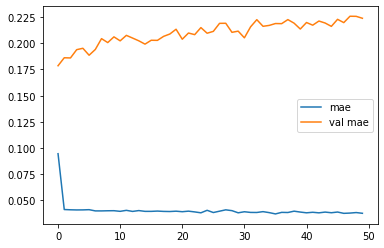

In [67]:
mae2_a = history2_a.history['mae']
val_mae2_a = history2_a.history['val_mae']
epoch2_a = range(len(mae2_a))

plt.plot(epoch2_a, mae2_a, label='mae')
plt.plot(epoch2_a, val_mae2_a, label='val mae')
plt.legend()
plt.show()

In [68]:
prediction2_a = forecast_predict(model2_a, test_telur_, time_size=win_size, batch_size=5)

data_result2_a = prediction2_a[(len(x_train))-win_size:-1, -1 ]
data_result2_a = scal_range.inverse_transform(data_result2_a.reshape(-1, 1))
data_result2_a = data_result2_a.reshape(-1)
mae2_a = tf.keras.metrics.mean_absolute_error(x_test, data_result2_a)
mape2_a = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result2_a)
mse2_a = tf.keras.metrics.mean_squared_error(x_test, data_result2_a)

rmse2_a = math.sqrt(mse2_a.numpy())
print(mae2_a.numpy(), mape2_a.numpy(), rmse2_a)

data_new_telur2_a = pd.DataFrame()
data_new_telur2_a['actual'] = x_test
data_new_telur2_a['prediction'] = data_result2_a
data_new_telur2_a.to_csv('telur_model3_adam_type1.csv')

data_new_telur2_a

131/131 [==============================] - 3s 19ms/step
1103.2092 4.267424 1536.4490717234985


,actual,prediction
0,26000,25516.083984
1,26000,25502.882812
2,25900,25528.767578
3,25950,25508.146484
4,26000,25537.957031
...,...,...
229,24400,25654.451172
230,25000,25699.503906
231,25650,25657.025391
232,28850,25743.294922


#### Type 2

In [69]:
history2_a1 = model2_a.fit(train_step1, epochs=50, validation_data=val_step)

Epoch 1/50
718/718 [==============================] - 16s 23ms/step - loss: 0.0053 - mae: 0.0548 - val_loss: 0.0561 - val_mae: 0.2139
Epoch 2/50
718/718 [==============================] - 16s 22ms/step - loss: 0.0051 - mae: 0.0544 - val_loss: 0.0551 - val_mae: 0.2111
Epoch 3/50
718/718 [==============================] - 17s 23ms/step - loss: 0.0049 - mae: 0.0536 - val_loss: 0.0677 - val_mae: 0.2349
Epoch 4/50
718/718 [==============================] - 16s 23ms/step - loss: 0.0048 - mae: 0.0521 - val_loss: 0.0592 - val_mae: 0.2172
Epoch 5/50
718/718 [==============================] - 17s 24ms/step - loss: 0.0048 - mae: 0.0525 - val_loss: 0.0592 - val_mae: 0.2176
Epoch 6/50
718/718 [==============================] - 16s 23ms/step - loss: 0.0048 - mae: 0.0522 - val_loss: 0.0509 - val_mae: 0.2003
Epoch 7/50
718/718 [==============================] - 16s 23ms/step - loss: 0.0049 - mae: 0.0525 - val_loss: 0.0572 - val_mae: 0.2119
Epoch 8/50
718/718 [==============================] - 17s 23ms

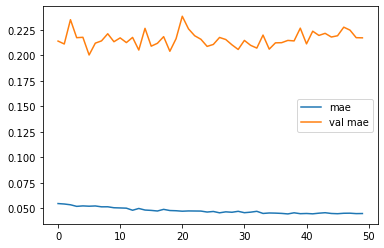

In [70]:
mae2_a1 = history2_a1.history['mae']
val_mae2_a1 = history2_a1.history['val_mae']
epoch2_a1 = range(len(mae2_a1))

plt.plot(epoch2_a1, mae2_a1, label='mae')
plt.plot(epoch2_a1, val_mae2_a1, label='val mae')
plt.legend()
plt.show()

199/199 [==============================] - 1s 5ms/step
1139.1034 4.3562384 1575.7019070877589


,actual,prediction
0,26000,25682.082031
1,26000,25736.816406
2,25900,25775.792969
3,25950,25791.035156
4,26000,25731.953125
...,...,...
229,24400,25040.421875
230,25000,25021.914062
231,25650,25170.468750
232,28850,25118.093750


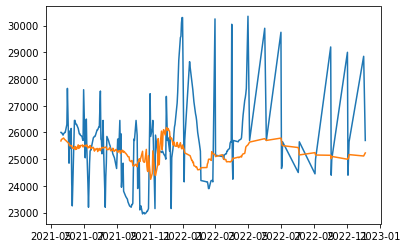

In [71]:
prediction2_a1 = forecast_predict(model2_a, test_telur_, time_size=win_size1, batch_size=5)

data_result2_a1 = prediction2_a1[(len(x_train))-win_size1:-1, -1 ]
data_result2_a1 = scal_range.inverse_transform(data_result2_a1.reshape(-1, 1))
data_result2_a1 = data_result2_a1.reshape(-1)
mae2_a1 = tf.keras.metrics.mean_absolute_error(x_test, data_result2_a1)
mape2_a1 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result2_a1)
mse2_a1 = tf.keras.metrics.mean_squared_error(x_test, data_result2_a1)

rmse2_a1 = math.sqrt(mse2_a1.numpy())
print(mae2_a1.numpy(), mape2_a1.numpy(), rmse2_a1)

data_new_telur2_a1 = pd.DataFrame()
data_new_telur2_a1['actual'] = x_test
data_new_telur2_a1['prediction'] = data_result2_a1
data_new_telur2_a1.to_csv('telur_model3_adam_type2.csv')

plt.plot(y_test, data_new_telur2_a1.actual)
plt.plot(y_test, data_new_telur2_a1.prediction)
data_new_telur2_a1

#### Type 3

In [72]:
history2_a2 = model2_a.fit(train_step2, epochs= 100, validation_data=val_step)

Epoch 1/100
84/84 [==============================] - 7s 86ms/step - loss: 0.0037 - mae: 0.0398 - val_loss: 0.0605 - val_mae: 0.2214
Epoch 2/100
84/84 [==============================] - 7s 83ms/step - loss: 0.0035 - mae: 0.0383 - val_loss: 0.0620 - val_mae: 0.2241
Epoch 3/100
84/84 [==============================] - 7s 83ms/step - loss: 0.0034 - mae: 0.0370 - val_loss: 0.0636 - val_mae: 0.2272
Epoch 4/100
84/84 [==============================] - 7s 84ms/step - loss: 0.0034 - mae: 0.0374 - val_loss: 0.0657 - val_mae: 0.2318
Epoch 5/100
84/84 [==============================] - 7s 84ms/step - loss: 0.0034 - mae: 0.0369 - val_loss: 0.0679 - val_mae: 0.2365
Epoch 6/100
84/84 [==============================] - 7s 85ms/step - loss: 0.0035 - mae: 0.0372 - val_loss: 0.0679 - val_mae: 0.2364
Epoch 7/100
84/84 [==============================] - 7s 83ms/step - loss: 0.0034 - mae: 0.0367 - val_loss: 0.0675 - val_mae: 0.2357
Epoch 8/100
84/84 [==============================] - 7s 85ms/step - loss: 0.

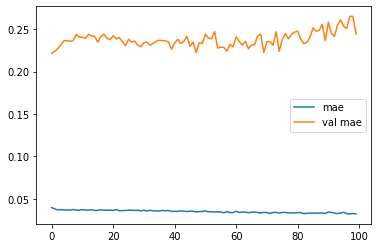

In [73]:
mae2_a2 = history2_a2.history['mae']
val_mae2_a2 = history2_a2.history['val_mae']
epoch2_a2 = range(len(mae2_a2))

plt.plot(epoch2_a2, mae2_a2, label='mae')
plt.plot(epoch2_a2, val_mae2_a2, label='val mae')
plt.legend()
plt.show()

191/191 [==============================] - 2s 8ms/step
1272.6832 4.857562 1732.3298617757532


,actual,prediction
0,26000,25809.216797
1,26000,26003.681641
2,25900,26090.539062
3,25950,26148.990234
4,26000,25987.330078
...,...,...
229,24400,25880.369141
230,25000,25870.373047
231,25650,25841.724609
232,28850,25890.064453


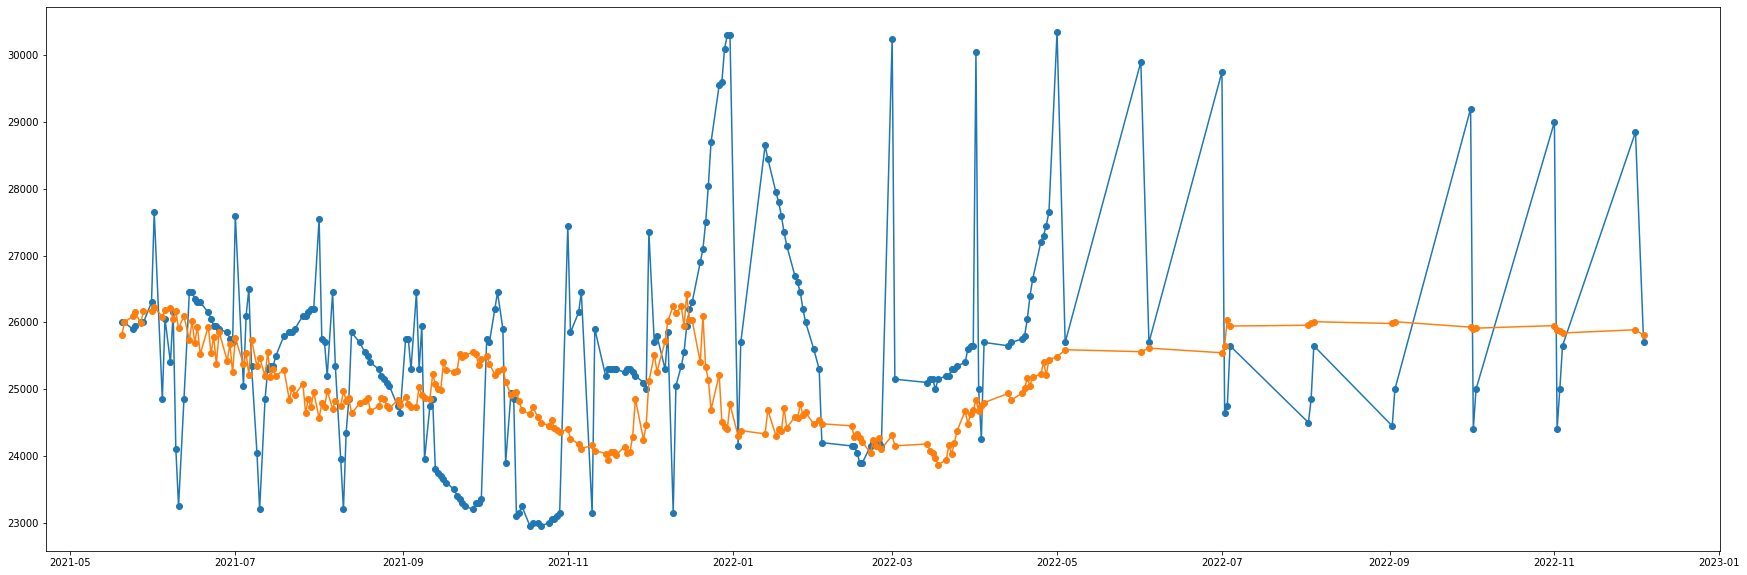

In [74]:
win_size = 100
prediction2_a2 = forecast_predict(model2_a, test_telur_, time_size=win_size, batch_size=5)

data_result2_a2 = prediction2_a2[(len(x_train))-win_size:-1, -1 ]
data_result2_a2 = scal_range.inverse_transform(data_result2_a2.reshape(-1, 1))
data_result2_a2 = data_result2_a2.reshape(-1)
mae2_a2 = tf.keras.metrics.mean_absolute_error(x_test, data_result2_a2)
mape2_a2 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result2_a2)
mse2_a2 = tf.keras.metrics.mean_squared_error(x_test, data_result2_a2)

rmse2_a2 = math.sqrt(mse2_a2.numpy())
print(mae2_a2.numpy(), mape2_a2.numpy(), rmse2_a2)

data_new_telur2_a2 = pd.DataFrame()
data_new_telur2_a2['actual'] = x_test
data_new_telur2_a2['prediction'] = data_result2_a2
data_new_telur2_a2.to_csv('telur_model3_adam_type3.csv')

plt.figure(figsize=(30, 10))
plt.plot(y_test,data_new_telur2_a2.actual, '-o')
plt.plot(y_test,data_new_telur2_a2.prediction, '-o')
data_new_telur2_a2